# Pyspark Tutorial

This tutorial includes training of a machine learning using `pyspark` package. Although the dataset we use is quite small, our aim is to perform actions in Spark to show its usage on datasets. First, we start with importing and creating a Spark session named `pyspark_ml_diabeter`.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('pyspark_ml_diabetes').getOrCreate()

Now we are ready to import our dataset and look at its columns.

In [2]:
df = spark.read.csv('./datasets/diabetes.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



We have $9$ columns in our dataset where $6$ of them are integer-valued and $2$ of them are floating numbers.

## Data Exploration

Let us first check whether there exists any missing values in the dataset. To perform this task, we need to use bunch of built-in functions like `isnull`, `when` and `count`.

In [3]:
from pyspark.sql.functions import isnull, when, count

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



The dependent variable `Outcome` has the following distribution:

In [4]:
df.groupby('Outcome').count().toPandas()

,Outcome,count
0,1,268
1,0,500


There are $268$ positive and $500$ negative occurance in the dataset. Let us have look at the relations of the columns in a scatter-plot.

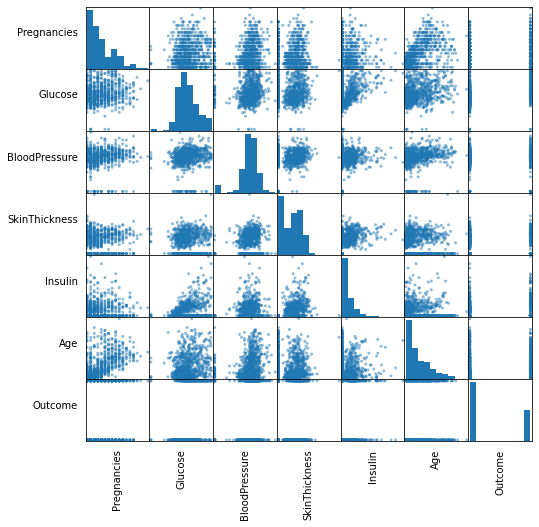

In [5]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']

from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Although the column `Pregnancies` has integer values, we can categorize the values into bins using `Bucketizer()` function in Pyspark. For the column, we will use the following bins:
- $0$ Pregnancies: 0
- $1$ Pregnancies: 1
- $2$ Pregnancies: 2
- $3$ Pregnancies: 3
- $4$ Pregnancies: 4
- $5+$ Pregnancies: 5

Then, we drop the original column and continue with `Pregnancy_Buckets`.

In [6]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits = [0, 1, 2, 3, 4, 5, float('Inf')],
                        inputCol = "Pregnancies", outputCol="Pregnancy_Buckets")
df_buck = bucketizer.setHandleInvalid("keep").transform(df)
df_buck = df_buck.drop('Pregnancies')
df_buck.show()

+-------+-------------+-------------+-------+----+------------------------+---+-------+-----------------+
|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|Pregnancy_Buckets|
+-------+-------------+-------------+-------+----+------------------------+---+-------+-----------------+
|    148|           72|           35|      0|33.6|                   0.627| 50|      1|              5.0|
|     85|           66|           29|      0|26.6|                   0.351| 31|      0|              1.0|
|    183|           64|            0|      0|23.3|                   0.672| 32|      1|              5.0|
|     89|           66|           23|     94|28.1|                   0.167| 21|      0|              1.0|
|    137|           40|           35|    168|43.1|                   2.288| 33|      1|              0.0|
|    116|           74|            0|      0|25.6|                   0.201| 30|      0|              5.0|
|     78|           50|           32|     88|3

Now, we can continue with a assembler to combine all required columns into a column as this is required by the machine learning modules in Spark.

In [7]:
features = ['Pregnancy_Buckets',
            'Glucose',
            'BloodPressure',
            'SkinThickness',
            'Insulin',
            'BMI',
            'DiabetesPedigreeFunction',
            'Age']

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features, outputCol='features')

transformed_data = assembler.transform(df_buck)

In [8]:
transformed_data.show()

+-------+-------------+-------------+-------+----+------------------------+---+-------+-----------------+--------------------+
|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|Pregnancy_Buckets|            features|
+-------+-------------+-------------+-------+----+------------------------+---+-------+-----------------+--------------------+
|    148|           72|           35|      0|33.6|                   0.627| 50|      1|              5.0|[5.0,148.0,72.0,3...|
|     85|           66|           29|      0|26.6|                   0.351| 31|      0|              1.0|[1.0,85.0,66.0,29...|
|    183|           64|            0|      0|23.3|                   0.672| 32|      1|              5.0|[5.0,183.0,64.0,0...|
|     89|           66|           23|     94|28.1|                   0.167| 21|      0|              1.0|[1.0,89.0,66.0,23...|
|    137|           40|           35|    168|43.1|                   2.288| 33|      1|              0.0|[0.0,1

We are done with preprocessing the data and now, it is ready for construction of the machine learning model.

## Model Construction

As usual, we need to split the dataset into training and test sets. In spark, we can use `randomSplit()` function for this purpose. We need to note that since the performance of the model depends on how we split the dataset into training and test. One should design a process like cross validation for the model generalization purposes. However, we continue with one splitting operation for illustration purposes.

In [9]:
(training_data, test_data) = transformed_data.randomSplit([0.8, 0.2])

We have obtained our training and test datasets. Now, we can call any classification method we want. In this tutorial, we will use Random Forest.

In [10]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Outcome', 
                            featuresCol='features',
                            maxDepth=5)

model = rf.fit(training_data)

rf_predictions = model.transform(test_data)

The model is trained using the training dataset and predicts the observations in the test dataset using `transform()` function. After this, we can evaluate the model using `BinaryClassificationEvaluator()`.

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator= BinaryClassificationEvaluator(labelCol = "Outcome", 
                                         rawPredictionCol="probability", 
                                         metricName= "areaUnderROC")

accuracy = evaluator.evaluate(rf_predictions)

print('Random Forest classifier Accuracy:', accuracy)

Random Forest classifier Accuracy: 0.7808493589743589
